#### Library

In [1]:
import pandas as pd
# Set pandas options to display all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)

from xgboost import XGBRegressor
import sklearn
from sklearn.metrics import mean_squared_error, r2_score
from catboost import CatBoostRegressor

#### Data Loading

In [2]:
df = pd.read_csv('/home/kevin/Downloads/BESS/data/raw/merged_df_2024_cleaned.csv')

#### Train-Test split

In [3]:
# Convert datetime_ column to datetime type
df['datetime_'] = pd.to_datetime(df['datetime_'])

# Filter data for the first 11 months
train_data = df[df['datetime_'] < '2024-12-01']
test_data = df[df['datetime_'] >= '2024-12-01']

# Define independent variables (features) and target variable
# X_train = train_data[['solar_generation', 'wind_generation', 'temp_calgary', 'temp_edmonton', 'temp_fortmc']]
X_train = train_data.drop(columns=['datetime_', 'pool_price'])
y_train = train_data['pool_price']

# Display the shapes of the training data
print(X_train.shape, y_train.shape)


# Filter data for the first 6 months
test_data = df[df['datetime_'] >= '2024-12-01']

# Define independent variables (features) and target variable
X_test = test_data.drop(columns=['datetime_', 'pool_price'])
y_test = test_data['pool_price']

# Display the shapes of the training data
print(X_test.shape, y_test.shape)

(8043, 65) (8043,)
(744, 65) (744,)


#### Model Training

In [8]:
# Initialize the CatBoost regressor
catboost_regressor = CatBoostRegressor(iterations=5000, learning_rate=0.1, depth=6, loss_function='RMSE')

# Specify the categorical features
categorical_features = ['season'] 

# Train the model
catboost_regressor.fit(X_train, y_train, cat_features=categorical_features, verbose=100)

# Display the model
print(catboost_regressor)

0:	learn: 119.4112984	total: 33.4ms	remaining: 2m 46s
100:	learn: 32.4789371	total: 1.3s	remaining: 1m 3s
200:	learn: 25.5274800	total: 2.87s	remaining: 1m 8s
300:	learn: 20.9713971	total: 4.16s	remaining: 1m 5s
400:	learn: 17.7557747	total: 5.46s	remaining: 1m 2s
500:	learn: 15.2251081	total: 6.71s	remaining: 1m
600:	learn: 13.3177761	total: 7.98s	remaining: 58.4s
700:	learn: 11.7755819	total: 9.29s	remaining: 57s
800:	learn: 10.4989103	total: 10.5s	remaining: 55s
900:	learn: 9.4245623	total: 11.7s	remaining: 53.2s
1000:	learn: 8.5320258	total: 12.9s	remaining: 51.5s
1100:	learn: 7.7567786	total: 14.1s	remaining: 49.8s
1200:	learn: 7.0330463	total: 15.2s	remaining: 48.2s
1300:	learn: 6.4124660	total: 16.5s	remaining: 46.9s
1400:	learn: 5.8567136	total: 17.6s	remaining: 45.3s
1500:	learn: 5.3907884	total: 18.8s	remaining: 43.9s
1600:	learn: 4.9597006	total: 20.3s	remaining: 43.2s
1700:	learn: 4.5877753	total: 21.6s	remaining: 41.8s
1800:	learn: 4.2325092	total: 22.8s	remaining: 40.4s
1

#### Train Inference

In [9]:
# Make predictions on the training data
y_train_pred = catboost_regressor.predict(X_train)

# Display the predictions
print(y_train_pred)
# Calculate mean squared error for training data
train_mse = mean_squared_error(y_train, y_train_pred)
print(f"Train Mean Squared Error: {train_mse}")

# Calculate R^2 score for training data
train_r2 = r2_score(y_train, y_train_pred)
print(f"Train R^2 Score: {train_r2}")

[22.61151698 22.59698827 23.07734379 ... 38.87666292 32.48693615
 21.48434121]
Train Mean Squared Error: 0.3401830080491535
Train R^2 Score: 0.9999795834681415


#### Test Inference

In [10]:
# Make predictions on the test data
y_pred = catboost_regressor.predict(X_test)

# Calculate mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Calculate R^2 score
r2 = r2_score(y_test, y_pred)
print(f"R^2 Score: {r2}")

Mean Squared Error: 533.4733643897819
R^2 Score: -0.01625104472638461


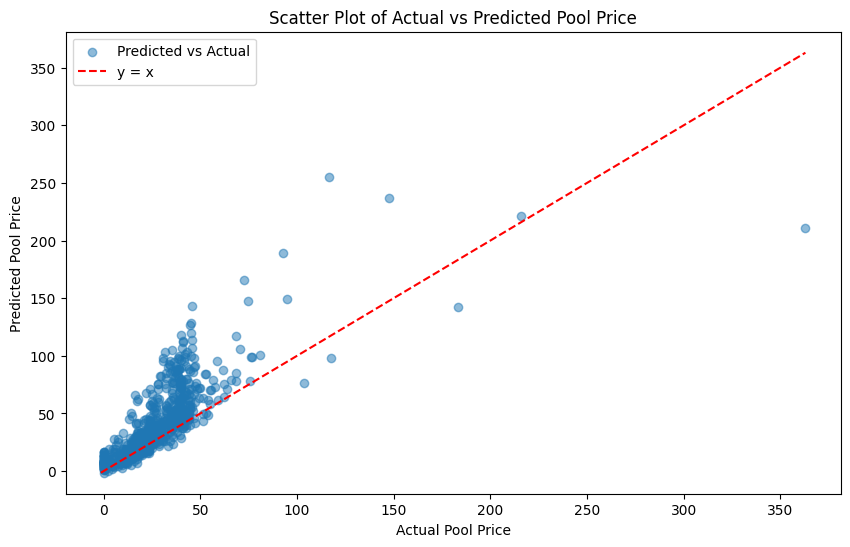

In [12]:
# Assuming y_test and y_pred are already defined
# Generate values for the y = x line
min_val = min(min(y_test), min(y_pred))
max_val = max(max(y_test), max(y_pred))
line_values = np.linspace(min_val, max_val, 100)

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label='Predicted vs Actual')

# Plot the y = x line
plt.plot(line_values, line_values, color='red', linestyle='--', label='y = x')

# Add labels and title
plt.xlabel('Actual Pool Price')
plt.ylabel('Predicted Pool Price')
plt.title('Scatter Plot of Actual vs Predicted Pool Price')

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
# train for higher iterations
# gather large data and train model (shown performance boost when trained on 2024 data relative to June_dec_2024 data)
# train LSTM model